In [23]:
shapeFile = "../data/shapeFiles/tl_2017_us_state.shp"
datafile = "../data/shapeFiles/daily_44201_2018.csv"
long = "Longitude"
lat = "Latitude"
pollutant = "Arithmetic Mean"
df = pd.read_csv(datafile)
shape_df = GeoDataFrame.from_file(shapeFile)
shape_df.drop(shape_df.index[[34, 35, 36, 40, 41, 49, 31]], 
              inplace=True)

In [24]:
shape_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"(POLYGON ((-82.987477 24.625379, -82.987477 24..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.784381 46.63050399999999, -96.78..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45880799999999 39.22027, -77.458..."


In [25]:
def bounds_minmax(bound1, bound2 = None):
    if bound2 is None:
        return bound1
    temp = []
    temp.append(min(bound1[0], bound2[0]))
    temp.append(min(bound1[1], bound2[1]))
    temp.append(max(bound1[2], bound2[2]))
    temp.append(max(bound1[3], bound2[3]))
    return temp

/home/apoorv/Desktop/github/.env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
No handles with labels found to put in legend.


SyntaxError: 'return' outside function (<ipython-input-27-82c37d015126>, line 142)

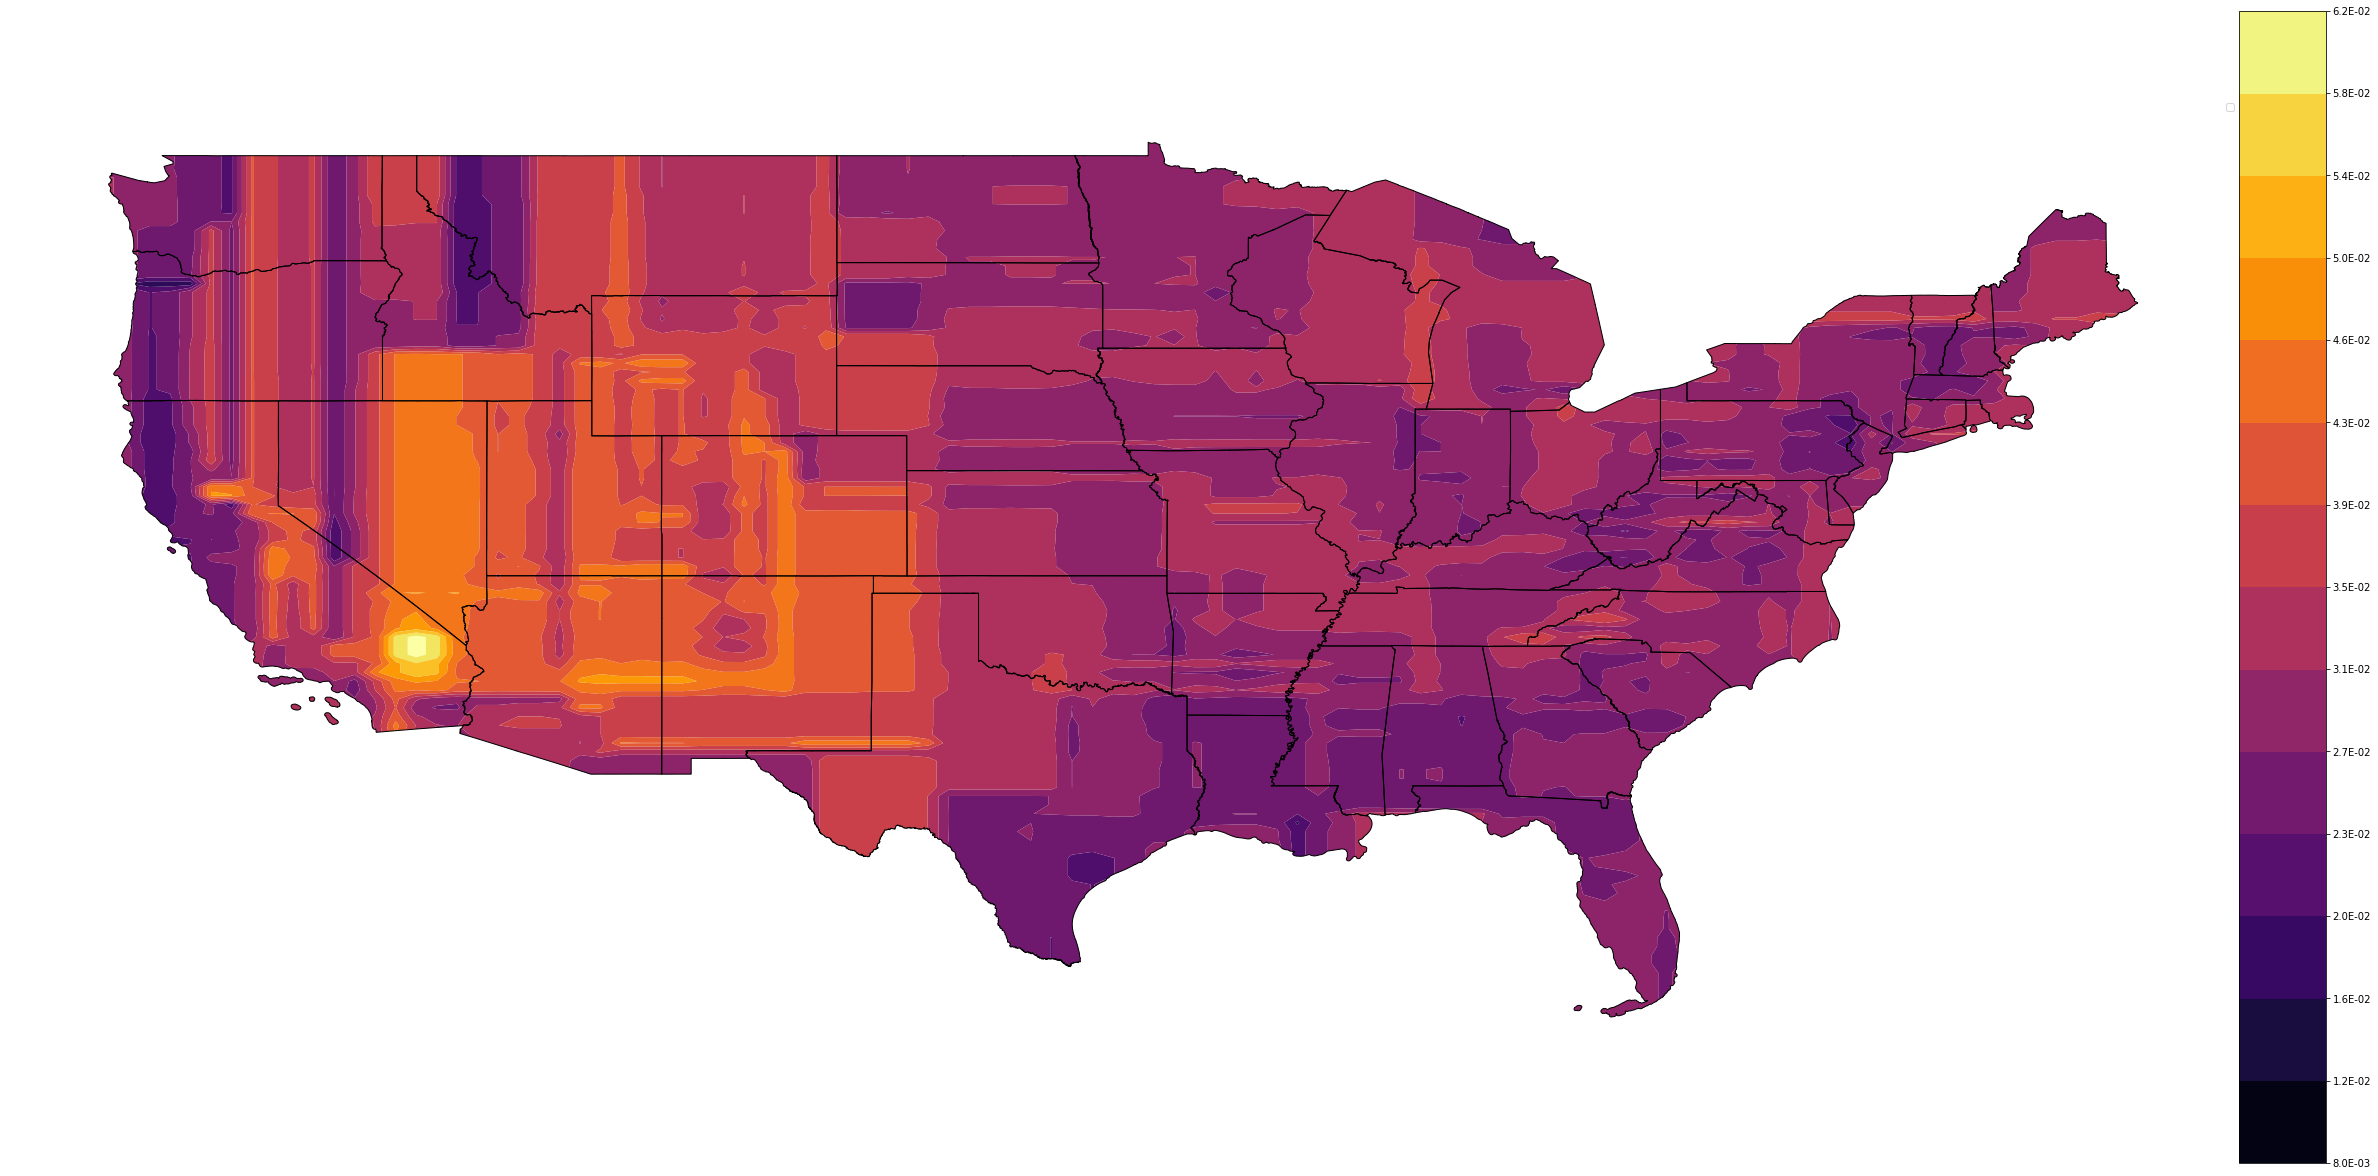

In [27]:
resolution=100
partitions=15
cmap="inferno"
Tcolor = 'red'
markersize = 3
plot_train_points=False
extrapolate=True

    import geopandas
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from geopandas import GeoDataFrame
    from sklearn.ensemble import RandomForestRegressor
    from matplotlib.colors import ListedColormap
    from shapely.geometry import (Polygon, MultiPolygon, Point)

    from polire.custom import CustomInterpolator

    df = df.sample(frac=1)
    trainX = df[[long, lat]].values
    trainy = df[pollutant].values

    def collec_to_gdf(collec_poly):
        """Transform a `matplotlib.contour.QuadContourSet` to a GeoDataFrame"""
        polygons, colors = [], []
        for i, polygon in enumerate(collec_poly.collections):
            mpoly = []
            for path in polygon.get_paths():
                try:
                    path.should_simplify = False
                    poly = path.to_polygons()
                    # Each polygon should contain an exterior ring + maybe hole(s):
                    exterior, holes = [], []
                    if len(poly) > 0 and len(poly[0]) > 3:
                        # The first of the list is the exterior ring :
                        exterior = poly[0]
                        # Other(s) are hole(s):
                        if len(poly) > 1:
                            holes = [h for h in poly[1:] if len(h) > 3]
                    mpoly.append(Polygon(exterior, holes))
                except:
                    print('Warning: Geometry error when making polygon #{}'
                        .format(i))
            if len(mpoly) > 1:
                mpoly = MultiPolygon(mpoly)
                polygons.append(mpoly)
                colors.append(polygon.get_facecolor().tolist()[0])
            elif len(mpoly) == 1:
                polygons.append(mpoly[0])
                colors.append(polygon.get_facecolor().tolist()[0])
        if type(collec_poly.cmap) != ListedColormap:
            raise ValueError("""We only support ListedColormap right now.\n"""
                """simply convert your cmap to ListedColormap using url here."""
                """https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html#sphx-glr-tutorials-colors-colormap-manipulation-py""")

        ixs = [collec_poly.cmap.colors.index(c[:3]) for c in colors]
        return GeoDataFrame(
            geometry=polygons,
            data={'RGBA': colors, 
                'cmapIX': ixs},
            crs={'init': 'epsg:4269'})

    z = trainy
    if not extrapolate:
        x1max, x2max = np.max(trainX, axis=0)
        x1min, x2min = np.min(trainX, axis=0)
    else:
        bounds = None
        for index, row in shape_df.iterrows():
            poly = row["geometry"]
            bounds = bounds_minmax(poly.bounds, bounds)

        x1max, x2max = bounds[2:]
        x1min, x2min = bounds[:2]
    xi = np.linspace(x1min, x1max, resolution)
    yi = np.linspace(x2min, x2max, resolution)
    Xi, Yi = np.meshgrid(xi, yi)
    t = CustomInterpolator(RandomForestRegressor)
    t.fit(trainX, z)

    zi = t.predict(np.asarray([Xi.ravel(), Yi.ravel()]).T)
    zi = zi.reshape(Xi.shape)

    vmin = zi.min()
    vmax = zi.max()
    collec_poly = plt.contourf(
        Xi, Yi, zi, partitions, vmin=vmin, vmax=vmax, cmap=cmap
    )
    plt.close()

    gdf = collec_to_gdf(collec_poly)
    # new min max vales in term of index of colors
    vmax2 = gdf.cmapIX.max()
    vmin2 = gdf.cmapIX.min()

    # intersection with shape_df
    inter = geopandas.overlay(shape_df, gdf, how='intersection')
    ax = inter.plot(
        column = 'cmapIX',
        cmap=cmap,
        figsize=(40, 40),
        vmax = vmax2,
        vmin = vmin2,
    )
    ax = shape_df.plot(
        ax = ax,
        color = 'none', 
        edgecolor='k',
        figsize=(40, 40)
    )
    # getting geodataframe of the train points
    if plot_train_points:
        geometry = [Point(xy) for xy in zip(df[long], df[lat])]
        geodf = geopandas.GeoDataFrame(
            df, crs={'init': 'epsg:4269'},
            geometry=geometry
        )

        # finding the intersection and plotting
        from geopandas.tools import sjoin
        inter2 = sjoin(geodf, shape_df)
        inter2.plot(
            ax = ax, color=Tcolor, label="Train points",
            markersize=markersize
        )

    plt.axis('off')
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.3, 0.03, 0.4])
    sm = plt.cm.ScalarMappable(
        cmap=cmap, 
        norm=plt.Normalize(vmin=vmin, vmax=vmax)
        )
    sm._A = []
    ax.legend()

    bounds = np.linspace(vmin, vmax, partitions)
    fig.colorbar(
        sm, cax=cax, ticks=bounds,
        boundaries=bounds, format='%1.1E')
    return ax


# =============================================================================
# from geopandas import GeoDataFrame
# import pandas as pd
# import matplotlib.pyplot as plt
# from vayu import interpolPlot

# shapeFile = "re/tl_2017_us_state.shp"
# long = "Longitude"
# lat = "Latitude"
# pollutant = "Arithmetic Mean"
# df = pd.read_csv("re/daily_44201_2018.csv")
# shape_df = GeoDataFrame.from_file(shapeFile)
# shape_df.drop(shape_df.index[[34, 35, 36, 40, 41, 49, 31]], inplace=True)
# interpolPlot(df, shape_df, long, lat, pollutant)
# plt.show()
# =============================================================================
